<a href="https://colab.research.google.com/github/MKY01/TensorFlow/blob/master/Copy_of_TensorFlow_Workshop_Video_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Workshop - Video Classification

<table align="left"><td>
  <a target="_blank"  href="https://www.meetup.com/gdgcloud/events/254274444/">
    <img src="https://secure.meetupstatic.com/photos/event/b/4/a/3/600_477046243.jpeg" /></a>
</td></table>

We have covered image recognition in [past workshops](https://www.youtube.com/watch?v=8_EH7CxxQ-s).  But video is another important medium form of communication.  

This notebook tries to undertake video classification.  More specifically, it tries to deal with a subset problem which is action recognition within a video scene.

Rather than develop a model from scratch which  can be a massive undertaking, we will use a model developed by [DeepMind](https://deepmind.com/) and that is available for us as the new tfhub dev : [tfhub.dev/deepmind/i3d-kinetics-400/1](https://tfhub.dev/deepmind/i3d-kinetics-400/1).

The underlying model is described in the paper "[Quo Vadis, Action Recognition? A New
Model and the Kinetics Dataset](https://arxiv.org/abs/1705.07750)" by Joao
Carreira and Andrew Zisserman. The paper was posted on arXiv in May 2017, and
was published as a CVPR 2017 conference paper.
The source code is publicly available on
[github](https://github.com/deepmind/kinetics-i3d).

"Quo Vadis" introduced a new architecture for video classification, the Inflated
3D Convnet or I3D. This architecture achieved state-of-the-art results on the UCF101
and HMDB51 datasets from fine-tuning these models. I3D models pre-trained on Kinetics
also placed first in the CVPR 2017 [Charades challenge](http://vuchallenge.org/charades.html).

The original module was trained on the [kinetics-400 dateset](https://deepmind.com/research/open-source/open-source-datasets/kinetics/)
and knows about 400 diferrent actions.
Labels for these actions can be found in the
[label map file](https://github.com/deepmind/kinetics-i3d/blob/master/data/label_map.txt).

Initially, the model is tested with different actions using the UCF video dataset.  But feel free to prepare new videos (from Youtube for example) to test the model for some of the challenges below.  
  
Good luck and Happy Coding!  
Yaz

# Challenges  
  
  

*   Explain in simple language what is going on
*   Test model for different action categories  
*   Save model and export it  
*   Find action category which does not work well (like surfing)
*   Retrain model for a not so reliable action category  
*   Retrain model for a totally new action category  
*   Determine whether the model can recognize small actions (like a facial reaction)
   
Choose a challenge based on your personal experience level and team.  

Document your work (in Google Docs for example) and leave a link to it in [this form](https://goo.gl/forms/D5Ay6qIaAxVgMtOm1)
  
 And this notebook will be updated with links to the best challenge responses!


# Setting up the environment

In [0]:
# Install the necessary python packages.
!pip install -q "tensorflow>=1.7" "tensorflow-hub" "imageio"

In [0]:
#@title Import the necessary modules
# TensorFlow and TF-Hub modules.
import tensorflow as tf
import tensorflow_hub as hub

tf.logging.set_verbosity(tf.logging.ERROR)

# Some modules to help with reading the UCF101 dataset.
import random
import re
import os
import tempfile
import cv2
import numpy as np

# Some modules to display an animation using imageio.
import imageio
from IPython import display

from urllib import request  # requires python3

In [0]:
#@title Helper functions for the UCF101 dataset

# Utilities to fetch videos from UCF101 dataset
UCF_ROOT = "http://crcv.ucf.edu/THUMOS14/UCF101/UCF101/"
_VIDEO_LIST = None
_CACHE_DIR = tempfile.mkdtemp()

def list_ucf_videos():
  """Lists videos available in UCF101 dataset."""
  global _VIDEO_LIST
  if not _VIDEO_LIST:
    index = request.urlopen(UCF_ROOT).read().decode("utf-8")
    videos = re.findall("(v_[\w_]+\.avi)", index)
    _VIDEO_LIST = sorted(set(videos))
  return list(_VIDEO_LIST)

def fetch_ucf_video(video):
  """Fetchs a video and cache into local filesystem."""
  cache_path = os.path.join(_CACHE_DIR, video)
  if not os.path.exists(cache_path):
    urlpath = request.urljoin(UCF_ROOT, video)
    print("Fetching %s => %s" % (urlpath, cache_path))
    data = request.urlopen(urlpath).read()
    open(cache_path, "wb").write(data)
  return cache_path

# Utilities to open video files using CV2
def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

def load_video(path, max_frames=0, resize=(224, 224)):
  cap = cv2.VideoCapture(path)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center_square(frame)
      frame = cv2.resize(frame, resize)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)
      
      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames) / 255.0

def animate(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=25)
  with open('./animation.gif','rb') as f:
      display.display(display.Image(data=f.read(), height=300))

In [0]:
#@title Get the kinetics-400 labels
# Get the kinetics-400 action labels from the GitHub repository.
KINETICS_URL = "https://raw.githubusercontent.com/deepmind/kinetics-i3d/master/data/label_map.txt"
with request.urlopen(KINETICS_URL) as obj:
  labels = [line.decode("utf-8").strip() for line in obj.readlines()]
print("Found %d labels." % len(labels))

Found 400 labels.


# Using the UCF101 dataset

In [0]:
# Get the list of videos in the dataset.
ucf_videos = list_ucf_videos()
  
categories = {}
for video in ucf_videos:
  category = video[2:-12]
  if category not in categories:
    categories[category] = []
  categories[category].append(video)
print("Found %d videos in %d categories." % (len(ucf_videos), len(categories)))

for category, sequences in categories.items():
  summary = ", ".join(sequences[:2])
  print("%-20s %4d videos (%s, ...)" % (category, len(sequences), summary))


Found 13320 videos in 101 categories.
ApplyEyeMakeup        145 videos (v_ApplyEyeMakeup_g01_c01.avi, v_ApplyEyeMakeup_g01_c02.avi, ...)
ApplyLipstick         114 videos (v_ApplyLipstick_g01_c01.avi, v_ApplyLipstick_g01_c02.avi, ...)
Archery               145 videos (v_Archery_g01_c01.avi, v_Archery_g01_c02.avi, ...)
BabyCrawling          132 videos (v_BabyCrawling_g01_c01.avi, v_BabyCrawling_g01_c02.avi, ...)
BalanceBeam           108 videos (v_BalanceBeam_g01_c01.avi, v_BalanceBeam_g01_c02.avi, ...)
BandMarching          155 videos (v_BandMarching_g01_c01.avi, v_BandMarching_g01_c02.avi, ...)
BaseballPitch         150 videos (v_BaseballPitch_g01_c01.avi, v_BaseballPitch_g01_c02.avi, ...)
BasketballDunk        131 videos (v_BasketballDunk_g01_c01.avi, v_BasketballDunk_g01_c02.avi, ...)
Basketball            134 videos (v_Basketball_g01_c01.avi, v_Basketball_g01_c02.avi, ...)
BenchPress            160 videos (v_BenchPress_g01_c01.avi, v_BenchPress_g01_c02.avi, ...)
Biking              

In [0]:
# Get a sample cricket video.
sample_video = load_video(fetch_ucf_video("v_CricketShot_g04_c02.avi"))

print("sample_video is a numpy array of shape %s." % str(sample_video.shape))
animate(sample_video)

In [0]:
# Run the i3d model on the video and print the top 5 actions.

# First add an empty dimension to the sample video as the model takes as input
# a batch of videos.
model_input = np.expand_dims(sample_video, axis=0)

# Create the i3d model and get the action probabilities.
with tf.Graph().as_default():
  i3d = hub.Module("https://tfhub.dev/deepmind/i3d-kinetics-400/1")
  input_placeholder = tf.placeholder(shape=(None, None, 224, 224, 3), dtype=tf.float32)
  logits = i3d(input_placeholder)
  probabilities = tf.nn.softmax(logits)
  with tf.train.MonitoredSession() as session:
    [ps] = session.run(probabilities,
                       feed_dict={input_placeholder: model_input})

print("Top 5 actions:")
for i in np.argsort(ps)[::-1][:5]:
  print("%-22s %.2f%%" % (labels[i], ps[i] * 100))

Top 5 actions:
playing cricket        97.77%
skateboarding          0.71%
robot dancing          0.56%
roller skating         0.56%
golf putting           0.13%


Fetching http://crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_CricketBowling_g01_c02.avi => /tmp/tmpqhv8df46/v_CricketBowling_g01_c02.avi
sample_video is a numpy array of shape (61, 224, 224, 3).


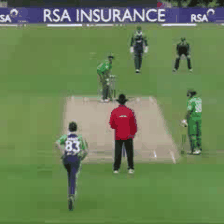

In [0]:
# Get a sample cricket bowling video.
sample_video = load_video(fetch_ucf_video("v_CricketBowling_g01_c02.avi"))

print("sample_video is a numpy array of shape %s." % str(sample_video.shape))
animate(sample_video)

In [0]:
# Run the i3d model on the video and print the top 5 actions.

# First add an empty dimension to the sample video as the model takes as input
# a batch of videos.
model_input = np.expand_dims(sample_video, axis=0)

# Create the i3d model and get the action probabilities.
with tf.Graph().as_default():
  i3d = hub.Module("https://tfhub.dev/deepmind/i3d-kinetics-400/1")
  input_placeholder = tf.placeholder(shape=(None, None, 224, 224, 3), dtype=tf.float32)
  logits = i3d(input_placeholder)
  probabilities = tf.nn.softmax(logits)
  with tf.train.MonitoredSession() as session:
    [ps] = session.run(probabilities,
                       feed_dict={input_placeholder: model_input})

print("Top 5 actions:")
for i in np.argsort(ps)[::-1][:5]:
  print("%-22s %.2f%%" % (labels[i], ps[i] * 100))

Top 5 actions:
playing cricket        99.91%
golf putting           0.05%
robot dancing          0.02%
shooting goal (soccer) 0.01%
catching or throwing baseball 0.00%


In [0]:
# Get a sample surfing video.
sample_video = load_video(fetch_ucf_video("v_Surfing_g01_c02.avi"))

print("sample_video is a numpy array of shape %s." % str(sample_video.shape))
animate(sample_video)

**Not so great at recognizing surfing!**  
![Too bad](https://media.giphy.com/media/3ohzdRmJspKrpKjL5C/source.gif)  


In [0]:
# Run the i3d model on the video and print the top 5 actions.

# First add an empty dimension to the sample video as the model takes as input
# a batch of videos.
model_input = np.expand_dims(sample_video, axis=0)

# Create the i3d model and get the action probabilities.
with tf.Graph().as_default():
  i3d = hub.Module("https://tfhub.dev/deepmind/i3d-kinetics-400/1")
  input_placeholder = tf.placeholder(shape=(None, None, 224, 224, 3), dtype=tf.float32)
  logits = i3d(input_placeholder)
  probabilities = tf.nn.softmax(logits)
  with tf.train.MonitoredSession() as session:
    [ps] = session.run(probabilities,
                       feed_dict={input_placeholder: model_input})

print("Top 5 actions:")
for i in np.argsort(ps)[::-1][:5]:
  print("%-22s %.2f%%" % (labels[i], ps[i] * 100))

Top 5 actions:
faceplanting           29.37%
ski jumping            24.94%
surfing water          22.11%
kitesurfing            7.30%
snowboarding           5.79%


In [0]:
# Get a sample typing video.
sample_video = load_video(fetch_ucf_video("v_Typing_g01_c02.avi"))

print("sample_video is a numpy array of shape %s." % str(sample_video.shape))
animate(sample_video)

In [0]:
# Run the i3d model on the video and print the top 5 actions.

# First add an empty dimension to the sample video as the model takes as input
# a batch of videos.
model_input = np.expand_dims(sample_video, axis=0)

# Create the i3d model and get the action probabilities.
with tf.Graph().as_default():
  i3d = hub.Module("https://tfhub.dev/deepmind/i3d-kinetics-400/1")
  input_placeholder = tf.placeholder(shape=(None, None, 224, 224, 3), dtype=tf.float32)
  logits = i3d(input_placeholder)
  probabilities = tf.nn.softmax(logits)
  with tf.train.MonitoredSession() as session:
    [ps] = session.run(probabilities,
                       feed_dict={input_placeholder: model_input})

print("Top 5 actions:")
for i in np.argsort(ps)[::-1][:5]:
  print("%-22s %.2f%%" % (labels[i], ps[i] * 100))

Top 5 actions:
using computer         100.00%
drumming fingers       0.00%
texting                0.00%
using remote controller (not gaming) 0.00%
recording music        0.00%


The Kinectics Dataset explained in a paper  
https://arxiv.org/abs/1705.06950  


full list of labels in this model  
https://raw.githubusercontent.com/deepmind/kinetics-i3d/master/data/label_map.txt  